In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
request_data = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/sample-hourly-request-rate.csv')

#Medium
Refer to https://rahulaga.medium.com/time-series-forecasting-with-facebook-prophet-f0468ff6fa3b

# Understanding the data

In [3]:
request_data.tail()

,Time,Point
667,5/6/21 14:00,640.439444
668,5/6/21 15:00,697.596944
669,5/6/21 16:00,647.408889
670,5/6/21 17:00,695.330556
671,5/6/21 18:00,675.820588


In [4]:
#convert type to datetime
request_data['Time'] = pd.to_datetime(request_data["Time"])

#For Prophet the time columns must be called ds and value as y
#note creating copy as going to set orginal Time as index
request_data['ds'] = request_data['Time']
request_data.rename(columns={'Point': 'y'}, inplace=True)

#set index as time for the series
request_data = request_data.set_index('Time')

In [5]:
request_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2021-04-08 19:00:00 to 2021-05-06 18:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       672 non-null    float64       
 1   ds      672 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


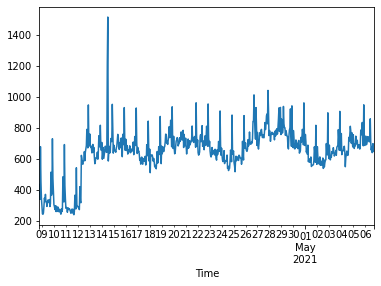

In [6]:
# plot everything
request_data['y'].plot()

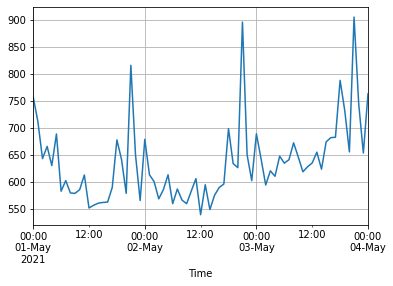

In [7]:
# view a subset of the data to zoom in
start_time = datetime(2021,5,1)
end_time = datetime(2021,5,4)

#subset of data
subset_request_data = request_data[(request_data.index >=start_time) & (request_data.index <= end_time)]
subset_request_data['y'].plot(grid=True)

# Stationarity

In [8]:
# show daily and weekly boxplot
df = pd.DataFrame(request_data)

df['week'] = [d.week for d in df.index]
df['day'] = [d.day for d in df.index]

#df.head()

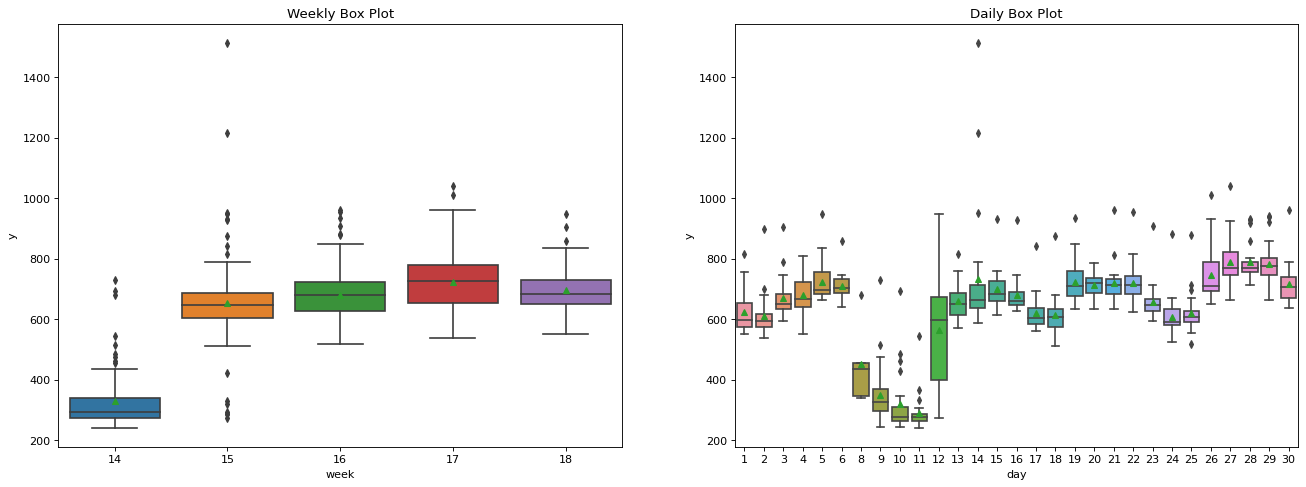

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='week', y='y', data=request_data, ax=axes[0], showmeans=True)
sns.boxplot(x='day', y='y', data=request_data, showmeans=True)

axes[0].set_title('Weekly Box Plot'); 
axes[1].set_title('Daily Box Plot')
plt.show()

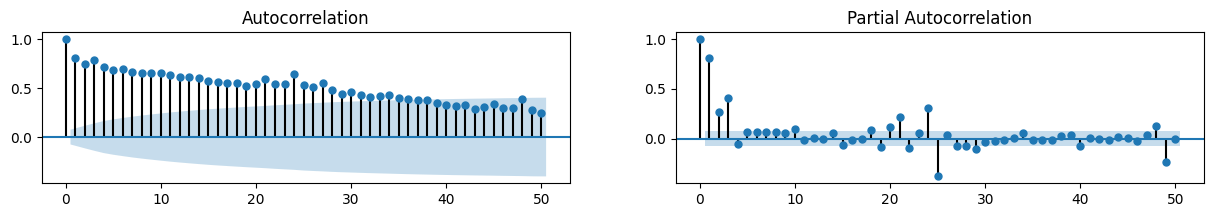

In [10]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(15,2), dpi= 100)
plot_acf(request_data.y.tolist(), lags=50, ax=axes[0]);
plot_pacf(request_data.y, lags=50, ax=axes[1]);

# Additive decompose

In [11]:
decomposition_a = sm.tsa.seasonal_decompose(request_data['y'], model='additive')
#decomposition_a_subset = sm.tsa.seasonal_decompose(subset_request_data['y'], model='additive')

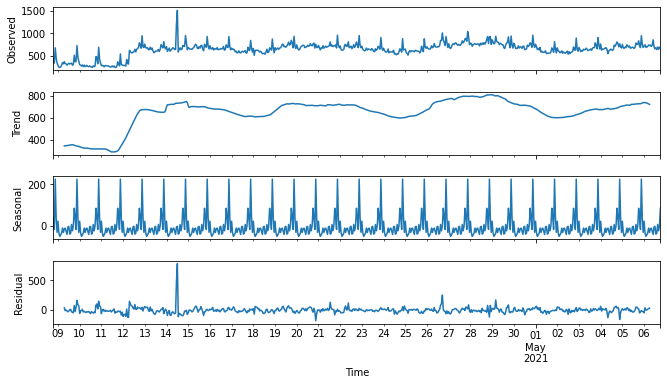

In [12]:
fig = decomposition_a.plot()
fig.set_size_inches(10,6)

#Multiplicative decompose

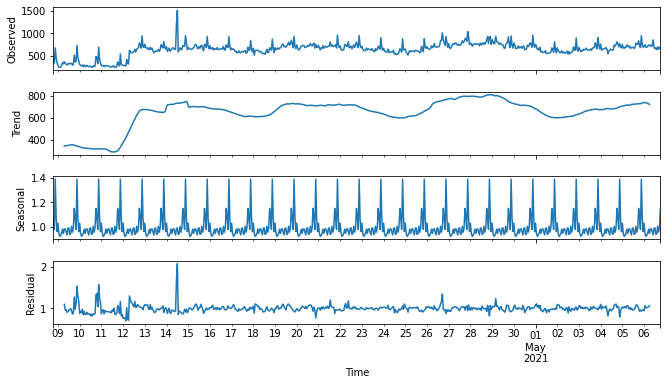

In [13]:
decomposition_m = sm.tsa.seasonal_decompose(request_data['y'], model='multiplicative')
fig = decomposition_m.plot()
fig.set_size_inches(10,6)

#Comparing additive and multiplicative

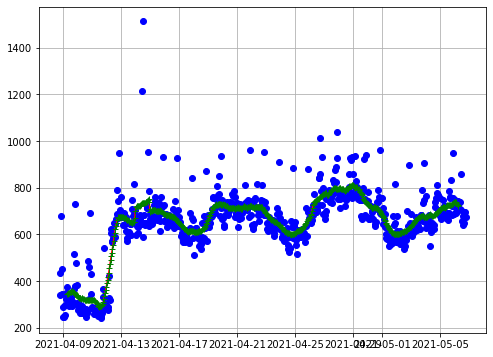

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.grid(True)
plt.plot(request_data.index, request_data['y'], 'bo', c='blue')
plt.plot(decomposition_a.trend.index, decomposition_a.trend, c='red')
plt.plot(decomposition_m.trend.index, decomposition_m.trend, 'r+', c='green')

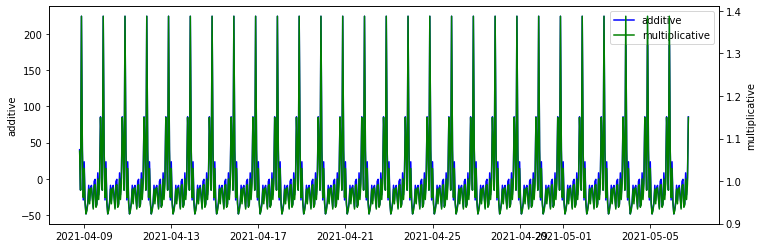

In [15]:
fig = plt.figure()
fig.set_size_inches(12, 4)

ax1 = fig.add_subplot()
ax1.set_ylabel('additive')
line1 = ax1.plot(decomposition_a.seasonal.index, decomposition_a.seasonal, c='blue', label='additive')

ax2 = ax1.twinx()  
ax2.set_ylabel('multiplicative')
line2 = ax2.plot(decomposition_m.seasonal.index, decomposition_m.seasonal, c='green', label='multiplicative')

lines = line1+line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0)

#Load observed future data
Loading next set of 7day data (7*24 rows)
Comparing this with forecast.

In [16]:
request_data_future = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/test-hourly-request-rate.csv')
print(request_data_future.shape)
request_data_future.tail()

(168, 2)


,Time,Point
163,5/13/21 14:00,856.887222
164,5/13/21 15:00,717.899167
165,5/13/21 16:00,709.526389
166,5/13/21 17:00,737.645278
167,5/13/21 18:00,855.658056


In [17]:
request_data_future['ds'] = request_data_future['Time']
#convert type to datetime
request_data_future['ds'] = pd.to_datetime(request_data_future['ds'])

request_data_future = request_data_future.set_index('Time')
request_data_future.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 5/6/21 19:00 to 5/13/21 18:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Point   168 non-null    float64       
 1   ds      168 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9+ KB


In [18]:
#compare forecast with 7day future (used below)
def compare_future(forecast, title):
  forecast_tail = forecast.tail(7*24)
  fig, ax = plt.subplots()
  fig.set_size_inches(15,4)
  ax.fill_between(forecast_tail.ds, forecast_tail['yhat_lower'], forecast_tail['yhat_upper'], alpha=0.2)
  line1 = plt.plot(forecast_tail.ds, forecast_tail['yhat'], c='blue', label='forecast')
  line2 = plt.plot(request_data_future.ds, request_data_future['Point'], c='red', label='observed')

  lines = line1+line2
  labels = [l.get_label() for l in lines]
  ax.legend(lines, labels, loc=0)

  plt.title(title)

#Facebook Prophet
https://rahulaga.medium.com/time-series-forecasting-with-facebook-prophet-f0468ff6fa3b

# FB prophet additive

In [19]:
#default is additive but using param anyway, increasing default confidience interval from .8 to .95
fb_additive = Prophet(seasonality_mode='additive', interval_width=0.95)
fb_additive.fit(request_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [20]:
# adding 7 days forcast to data frame. note data is hourly so adding 7*24 periods
future_dates_additive = fb_additive.make_future_dataframe(periods=7*24, freq='H')
future_dates_additive.tail()

,ds
835,2021-05-13 14:00:00
836,2021-05-13 15:00:00
837,2021-05-13 16:00:00
838,2021-05-13 17:00:00
839,2021-05-13 18:00:00


In [21]:
forecast_additive = fb_additive.predict(future_dates_additive)
forecast_additive.tail()
# yhat is the the predicted value and lower/upper is the predicted range
# note predicted values of componets as well

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
835,2021-05-13 14:00:00,563.593664,415.171461,776.442853,468.054210,659.109503,23.656876,23.656876,23.656876,-21.630184,-21.630184,-21.630184,45.287060,45.287060,45.287060,0.0,0.0,0.0,587.250541
836,2021-05-13 15:00:00,563.123489,415.848039,776.402623,466.963919,659.946150,26.815870,26.815870,26.815870,-14.966736,-14.966736,-14.966736,41.782606,41.782606,41.782606,0.0,0.0,0.0,589.939359
837,2021-05-13 16:00:00,562.653313,419.000759,775.354148,465.873629,660.780050,33.169116,33.169116,33.169116,-5.061817,-5.061817,-5.061817,38.230932,38.230932,38.230932,0.0,0.0,0.0,595.822429
838,2021-05-13 17:00:00,562.183137,440.436878,771.893310,464.783339,661.596988,44.273934,44.273934,44.273934,9.617733,9.617733,9.617733,34.656201,34.656201,34.656201,0.0,0.0,0.0,606.457071
839,2021-05-13 18:00:00,561.712962,468.668464,800.131666,463.693048,661.584333,62.793047,62.793047,62.793047,31.711080,31.711080,31.711080,31.081966,31.081966,31.081966,0.0,0.0,0.0,624.506008


In [22]:
forecast_additive[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
835,2021-05-13 14:00:00,587.250541,415.171461,776.442853
836,2021-05-13 15:00:00,589.939359,415.848039,776.402623
837,2021-05-13 16:00:00,595.822429,419.000759,775.354148
838,2021-05-13 17:00:00,606.457071,440.436878,771.893310
839,2021-05-13 18:00:00,624.506008,468.668464,800.131666


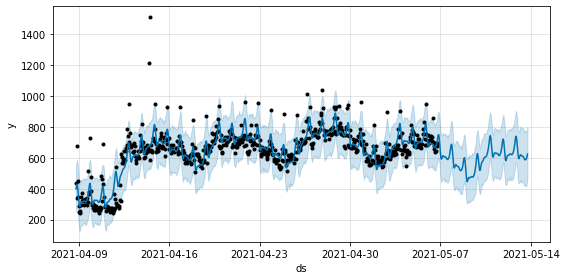

In [23]:
fb_additive.plot(forecast_additive, uncertainty=True, figsize=(8,4));
#black dots are actual, blue line is from model

In [24]:
#an interactive plot with plotly instead 
plot_plotly(fb_additive, forecast_additive)

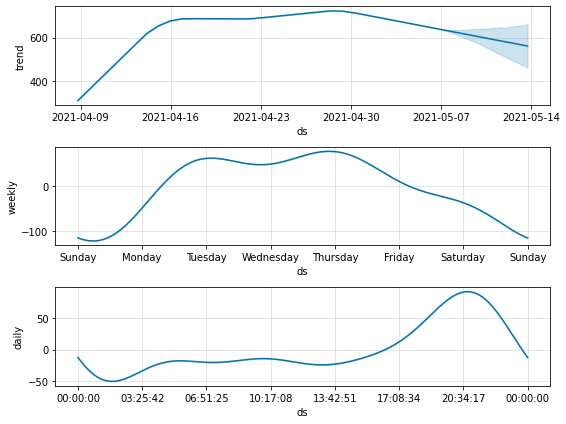

In [25]:
fb_additive.plot_components(forecast_additive, figsize=(8,6));

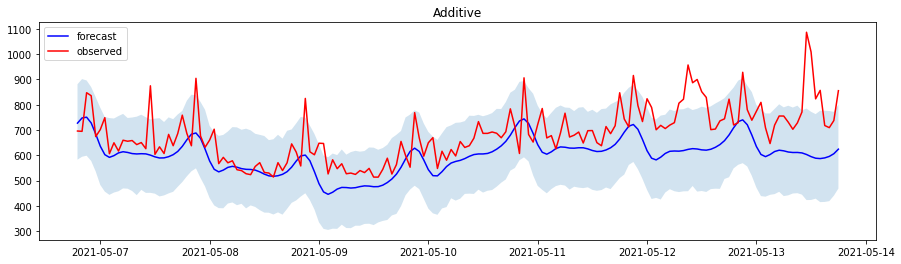

In [26]:
compare_future(forecast_additive, 'Additive')

# FB prophet mutliplicative

In [27]:
fb_multi = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
fb_multi.fit(request_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [28]:
future_dates_multi = fb_multi.make_future_dataframe(periods=7*24, freq='H')
forecast_multi = fb_multi.predict(future_dates_multi)
forecast_multi.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
835,2021-05-13 14:00:00,568.365873,408.602770,756.126079,476.824341,668.492390,-0.032879,-0.032879,-0.032879,0.031903,0.031903,0.031903,0.064782,0.064782,0.064782,0.0,0.0,0.0,586.498232
836,2021-05-13 15:00:00,567.914652,403.037208,772.189768,475.731002,668.791222,-0.021613,-0.021613,-0.021613,0.038232,0.038232,0.038232,0.059845,0.059845,0.059845,0.0,0.0,0.0,589.627078
837,2021-05-13 16:00:00,567.463430,398.562632,774.798879,474.637664,669.651602,-0.005417,-0.005417,-0.005417,0.049436,0.049436,0.049436,0.054854,0.054854,0.054854,0.0,0.0,0.0,595.516719
838,2021-05-13 17:00:00,567.012209,415.642621,794.016873,473.544325,670.510107,0.016775,0.016775,0.016775,0.066616,0.066616,0.066616,0.049841,0.049841,0.049841,0.0,0.0,0.0,604.784522
839,2021-05-13 18:00:00,566.560988,439.246917,800.979207,472.450987,670.889309,0.048285,0.048285,0.048285,0.093124,0.093124,0.093124,0.044839,0.044839,0.044839,0.0,0.0,0.0,619.321331


In [29]:
plot_plotly(fb_multi, forecast_multi)

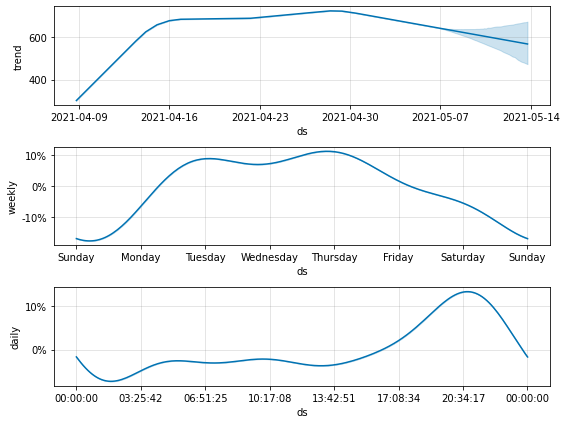

In [30]:
fb_multi.plot_components(forecast_multi, figsize=(8,6));

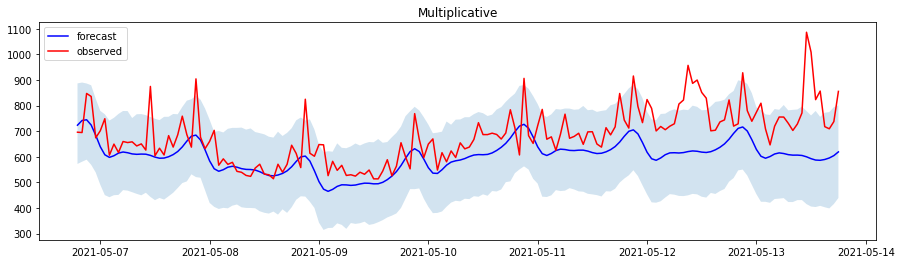

In [31]:
compare_future(forecast_multi, 'Multiplicative')

# ARIMA and SARIMA
Refer to Medium https://rahulaga.medium.com/time-series-forecasting-with-sarima-a0e3b15db059

In [32]:
# add MA using 24 data points (hourly data)
request_data['day_moving_avg'] = request_data.y.rolling(24).mean()
request_data.head(50)

,y,ds,week,day,day_moving_avg
Time,,,,,
2021-04-08 19:00:00,434.659444,2021-04-08 19:00:00,14,8,NaN
2021-04-08 20:00:00,340.232222,2021-04-08 20:00:00,14,8,NaN
2021-04-08 21:00:00,679.220833,2021-04-08 21:00:00,14,8,NaN
2021-04-08 22:00:00,453.507222,2021-04-08 22:00:00,14,8,NaN
2021-04-08 23:00:00,345.185833,2021-04-08 23:00:00,14,8,NaN
2021-04-09 00:00:00,290.373611,2021-04-09 00:00:00,14,9,NaN
2021-04-09 01:00:00,246.753889,2021-04-09 01:00:00,14,9,NaN
2021-04-09 02:00:00,244.257778,2021-04-09 02:00:00,14,9,NaN
2021-04-09 03:00:00,253.098889,2021-04-09 03:00:00,14,9,NaN


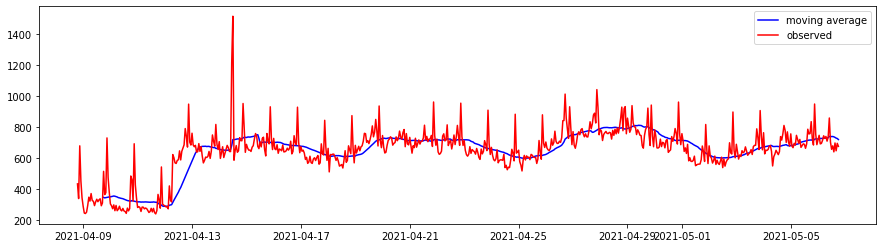

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(15,4)
line1 = plt.plot(request_data.ds, request_data['day_moving_avg'], c='blue', label='moving average')
line2 = plt.plot(request_data.ds, request_data['y'], c='red', label='observed')

lines = line1+line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=0)

In [34]:
# https://alkaline-ml.com/pmdarima/index.html
!pip install pmdarima

     |████████████████████████████████| 1.5MB 34.3MB/s 
     |████████████████████████████████| 9.5MB 47.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


### Data has seasonality so Arima just for sake of it

In [35]:
from pmdarima import auto_arima 
# auto arima helps figure out all parameters
arima_model = auto_arima(request_data['y'], seasonal=False)
arima_model.summary()
# not p,q,d values, looks like ARIMA (4,1,1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -3872.125
Date:                Mon, 24 May 2021   AIC                           7756.251
Time:                        22:14:26   BIC                           7783.303
Sample:                             0   HQIC                          7766.729
                                - 672                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3710      0.043      8.598      0.000       0.286       0.456
ar.L2         -0.0580      0.037     -1.560      0.119      -0.131       0.015
ar.L3          0.3327      0.032     10.508      0.000       0.271       0.395
ar.L4         -0.1468      0.041     -3.540      0.000      -0.228      -0.066
ma.L1         -0.8928      0.041    -21.694      0.000      -0.974      -0.812
sigma2      6014.7745    136.228     44.152      0.000    5747.773    6281.776
===================================================================================
Ljung-Box (Q):                      206.86   Jarque-Bera (JB):              4905.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             1.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
#Arima Prediction
arima_predictions = pd.DataFrame(arima_model.predict(n_periods=7*24), columns=['arima'])
arima_predictions['ds'] = request_data_future['ds'].to_numpy()
arima_predictions
# note, appears flat line but it is not, note value changes

,arima,ds
0,672.492092,2021-05-06 19:00:00
1,695.698059,2021-05-06 20:00:00
2,690.976614,2021-05-06 21:00:00
3,689.635691,2021-05-06 22:00:00
4,697.621111,2021-05-06 23:00:00
...,...,...
163,696.681495,2021-05-13 14:00:00
164,696.681495,2021-05-13 15:00:00
165,696.681495,2021-05-13 16:00:00
166,696.681495,2021-05-13 17:00:00


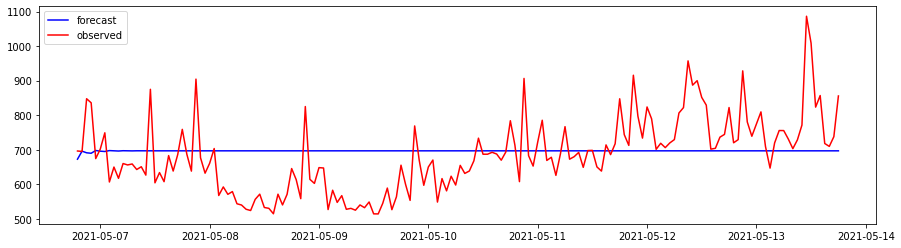

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(15,4)
line1 = plt.plot(arima_predictions.ds, arima_predictions['arima'], c='blue', label='forecast')
line2 = plt.plot(request_data_future.ds, request_data_future['Point'], c='red', label='observed')

lines = line1+line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=0)

### SARIMA

In [38]:
#Note this take a very long time to run. Setting seasonal true and m is the seasonal period
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
sarima_model = auto_arima(request_data['y'], seasonal=True, m=24)
sarima_model.summary()
# Note p,q,d and P,Q,D values

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  672
Model:             SARIMAX(1, 1, 2)x(2, 0, 0, 24)   Log Likelihood               -3743.141
Date:                            Mon, 24 May 2021   AIC                           7498.283
Time:                                    22:30:50   BIC                           7525.336
Sample:                                         0   HQIC                          7508.761
                                            - 672                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2729      0.094     -2.915      0.004      -0.456      -0.089
ma.L1         -0.1155      0.089     -1.291      0.197      -0.291       0.060
ma.L2         -0.4346      0.033    -13.203      0.000      -0.499      -0.370
ar.S.L24       0.3752      0.018     21.259      0.000       0.341       0.410
ar.S.L48       0.3259      0.019     17.008      0.000       0.288       0.363
sigma2      4011.3373     88.740     45.203      0.000    3837.410    4185.265
===================================================================================
Ljung-Box (Q):                       30.83   Jarque-Bera (JB):             16826.61
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
#SArima Prediction
sarima_predictions = pd.DataFrame(sarima_model.predict(n_periods=7*24), columns=['sarima'])
sarima_predictions['ds'] = request_data_future['ds'].to_numpy()
sarima_predictions

,sarima,ds
0,652.441526,2021-05-06 19:00:00
1,642.572000,2021-05-06 20:00:00
2,755.374083,2021-05-06 21:00:00
3,663.150889,2021-05-06 22:00:00
4,628.941109,2021-05-06 23:00:00
...,...,...
163,530.988826,2021-05-13 14:00:00
164,542.972376,2021-05-13 15:00:00
165,535.187293,2021-05-13 16:00:00
166,541.238623,2021-05-13 17:00:00


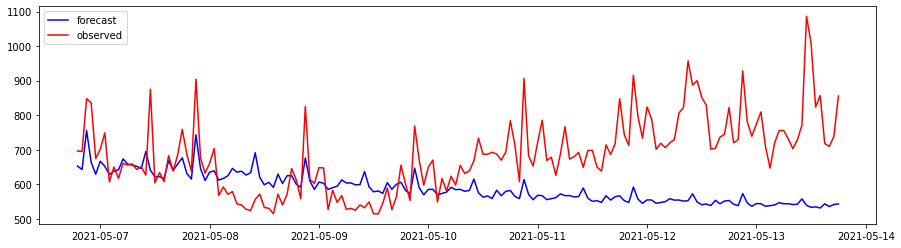

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(15,4)
line1 = plt.plot(sarima_predictions.ds, sarima_predictions['sarima'], c='blue', label='forecast')
line2 = plt.plot(request_data_future.ds, request_data_future['Point'], c='red', label='observed')

lines = line1+line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=0)

# save forecasts for use in next topic


In [41]:
forecast_multi.to_csv("predictions-fb-multi.csv", index=False)
forecast_additive.to_csv("predictions-fb-additive.csv", index=False)

arima_predictions.to_csv("predictions-arima.csv", index=False)
sarima_predictions.to_csv("predictions-sarima.csv", index=False)